In [41]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [42]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import loren_frank_data_processing as lfdp
import spectral_connectivity
import ripple_detection
import replay_classification

import logging
logging.basicConfig(level=logging.INFO)

In [43]:
epoch_key = ('HPa', 6, 2)

In [162]:
from loren_frank_data_processing import (get_LFP_dataframe,
                                         make_neuron_dataframe,
                                         make_tetrode_dataframe, save_xarray)
from src.analysis import (compare_spike_coherence, connectivity_by_ripple_type,
                          decode_ripple_clusterless, detect_epoch_ripples,
                          ripple_locked_firing_rate_change,
                          ripple_spike_coherence,
                          ripple_triggered_connectivity)
from src.spike_models import (fit_ripple_constant, fit_ripple_over_time, fit_replay)
from src.parameters import (ANIMALS, FREQUENCY_BANDS, MULTITAPER_PARAMETERS,
                            REPLAY_COVARIATES, SAMPLING_FREQUENCY,
                            PROCESSED_DATA_DIR)

ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, SAMPLING_FREQUENCY)

replay_info, decision_state_probability, posterior_density = decode_ripple_clusterless(
    epoch_key, ANIMALS, ripple_times, confidence_threshold=0.8)

neuron_info = make_neuron_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False).query('numspikes > 0')


INFO:src.analysis:Detecting ripples
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
INFO:src.analysis:Decoding ripples
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...
INFO:src.analysis:Predicting replay types


In [58]:
from loren_frank_data_processing import get_interpolated_position_dataframe

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)

ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat


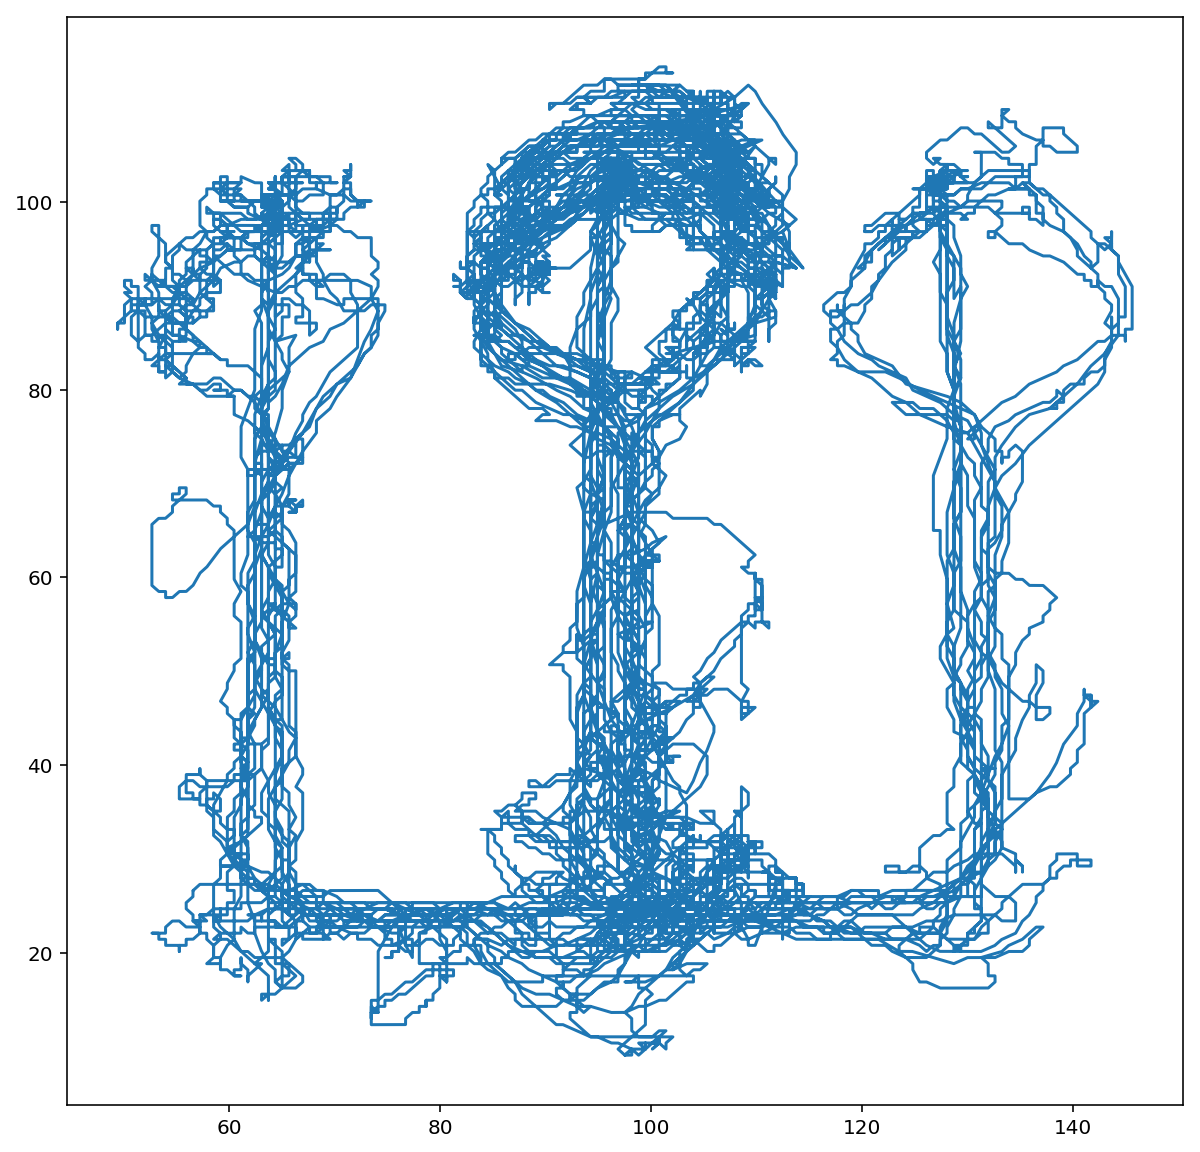

In [6]:
plt.figure(figsize=(10, 10))
plt.plot(position_info.x_position.values, position_info.y_position.values);

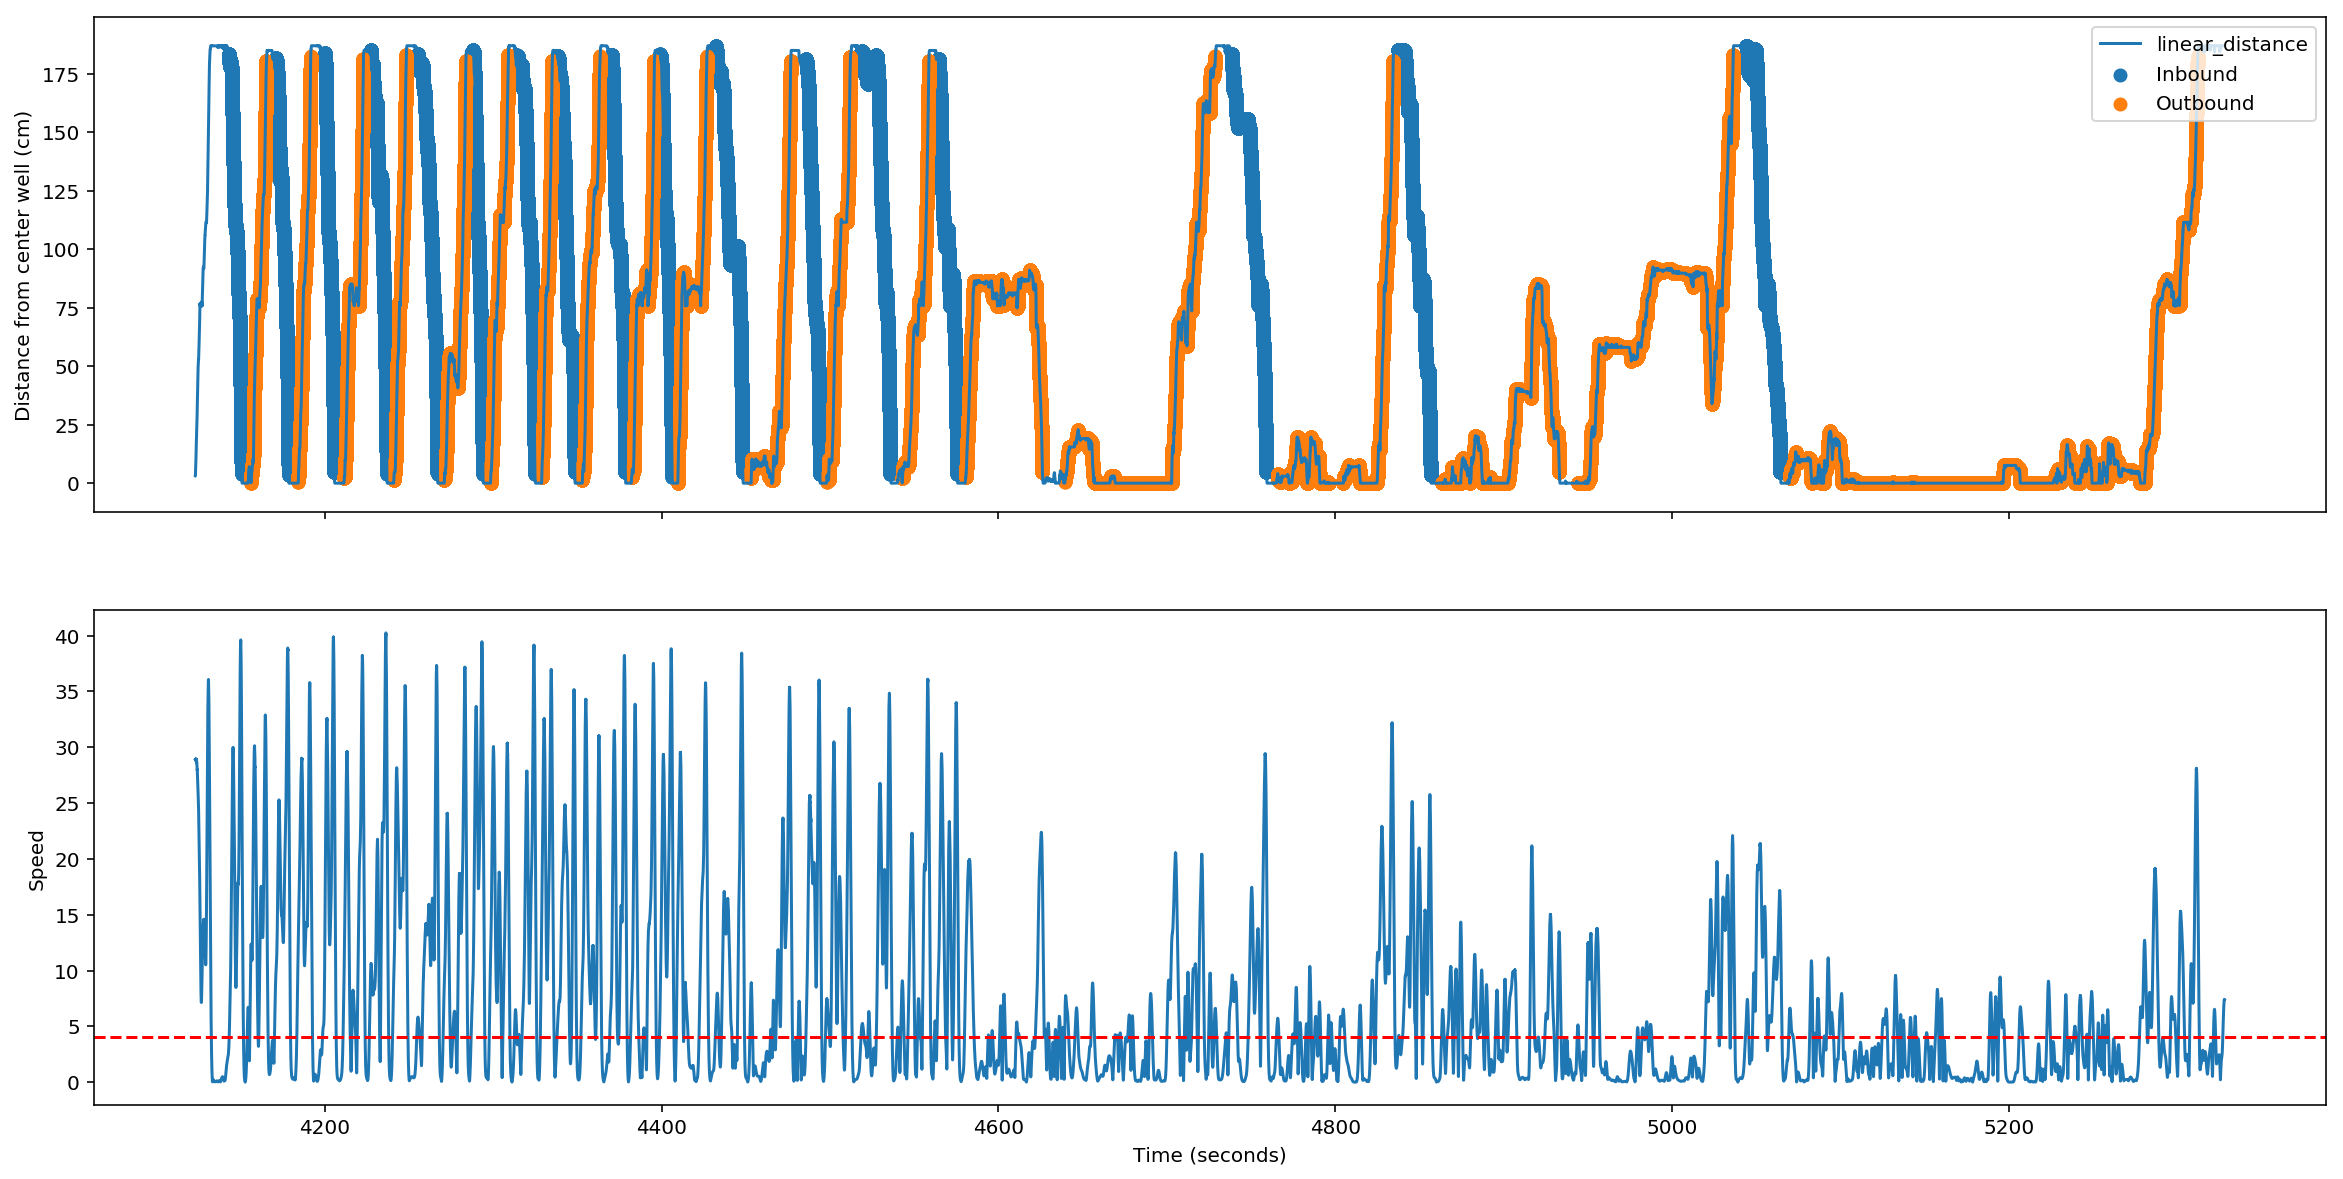

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

axes[0].plot(position_info.index.total_seconds(), position_info.linear_distance)

for label, df in position_info.groupby('task'):
    axes[0].scatter(df.index.total_seconds(), df.linear_distance, label=label)

axes[0].set_ylabel('Distance from center well (cm)')
axes[0].legend();

axes[1].plot(position_info.index.total_seconds(), position_info.speed);
axes[1].set_ylabel('Speed')
axes[1].axhline(4, color='red', linestyle='--')
axes[1].set_xlabel('Time (seconds)');

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=5)
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=4122.992, n_tapers=5)


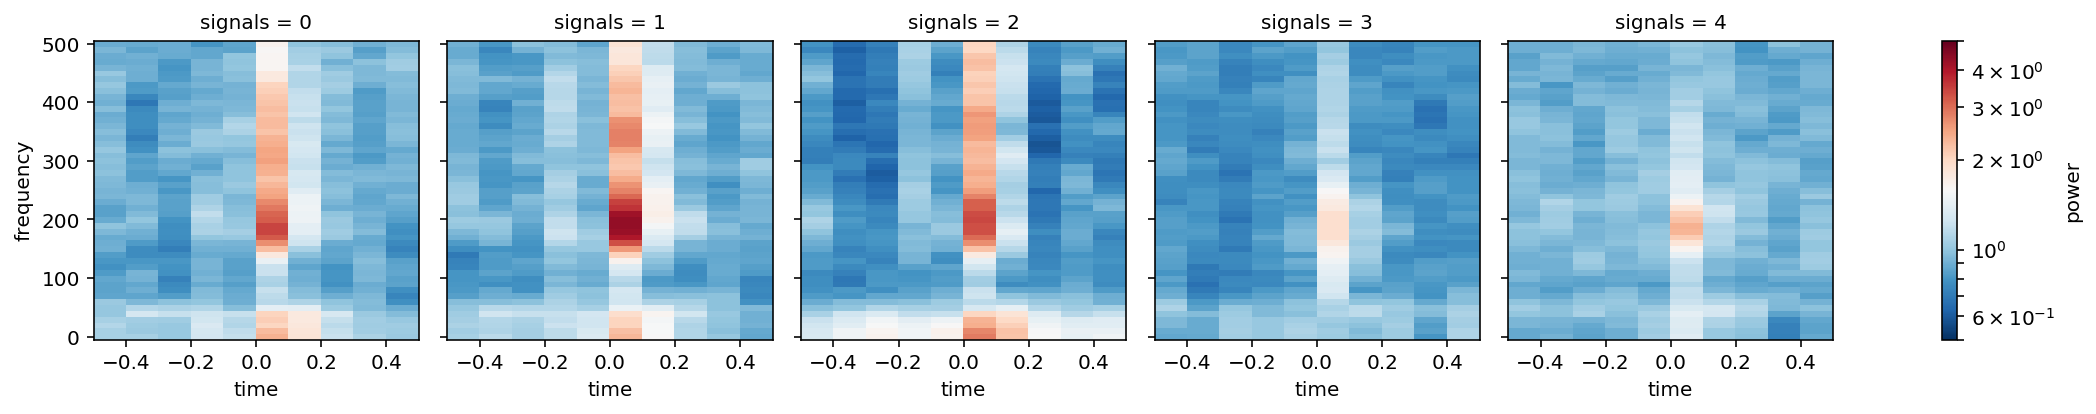

In [8]:
from loren_frank_data_processing import reshape_to_segments, make_tetrode_dataframe, get_LFPs
from matplotlib.colors import LogNorm

window_offset = (-0.5, 0.5)

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
is_brain_areas = (tetrode_info.area.isin(['CA1']) &
                 (tetrode_info.descrip == 'riptet'))
tetrode_keys = tetrode_info[is_brain_areas].index
hippocampus_lfps = get_LFPs(tetrode_keys, ANIMALS)

ripple_locked_LFPs = reshape_to_segments(
    hippocampus_lfps, ripple_times,
    window_offset=window_offset, sampling_frequency=SAMPLING_FREQUENCY)
ripple_locked_LFPs.columns = tetrode_info[is_brain_areas].tetrode_id
ripple_locked_LFPs = (ripple_locked_LFPs.to_xarray()
                      .to_array(dim='signals').transpose('time', 'ripple_number', 'signals'))
m = spectral_connectivity.Multitaper(
    ripple_locked_LFPs.values, SAMPLING_FREQUENCY, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=window_offset[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
ripple_locked_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')


m = spectral_connectivity.Multitaper(
    hippocampus_lfps.values, SAMPLING_FREQUENCY, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=hippocampus_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')

vmin, vmax = 0.5, 5

(ripple_locked_power / power.mean('time')).sel(frequency=slice(0, 500)).plot(
    x='time', y='frequency', col='signals', col_wrap=5, center=0,
    norm=LogNorm(vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
    cmap='RdBu_r');

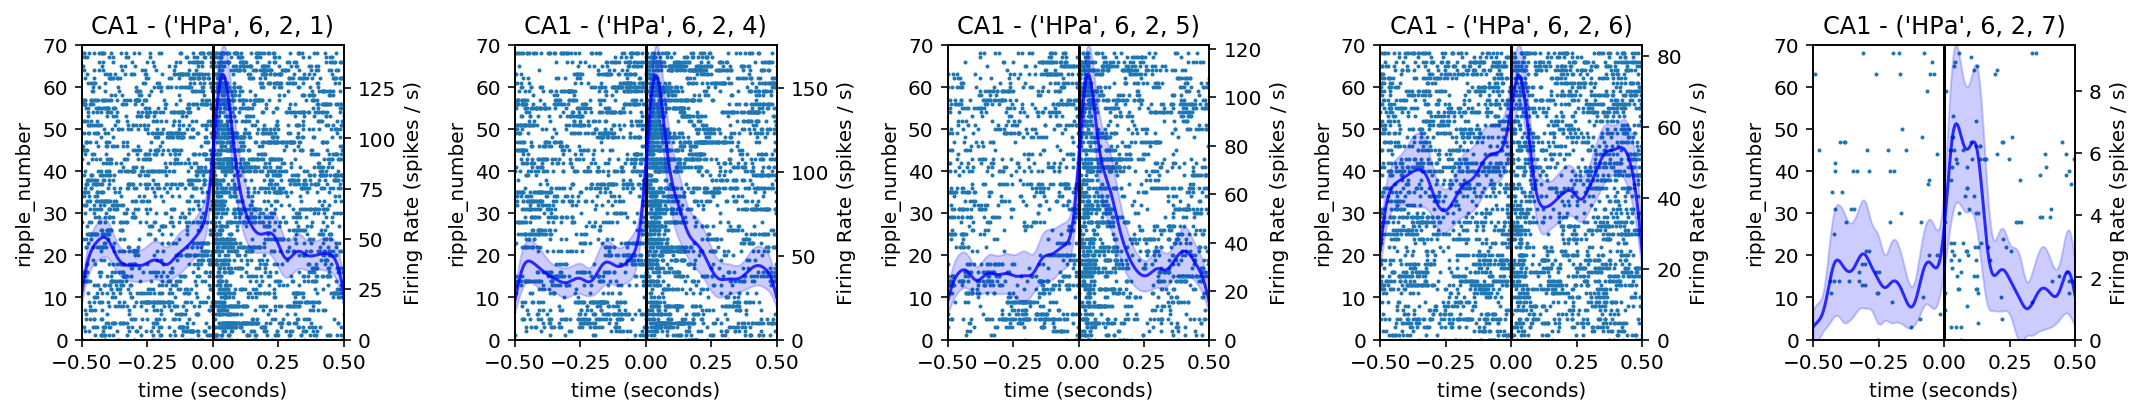

In [9]:
from src.visualization import plot_perievent_raster

ca1_keys = tetrode_info.loc[is_brain_areas].index
n_tetrodes = len(ca1_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), ca1_keys):
    plot_perievent_raster(tetrode_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

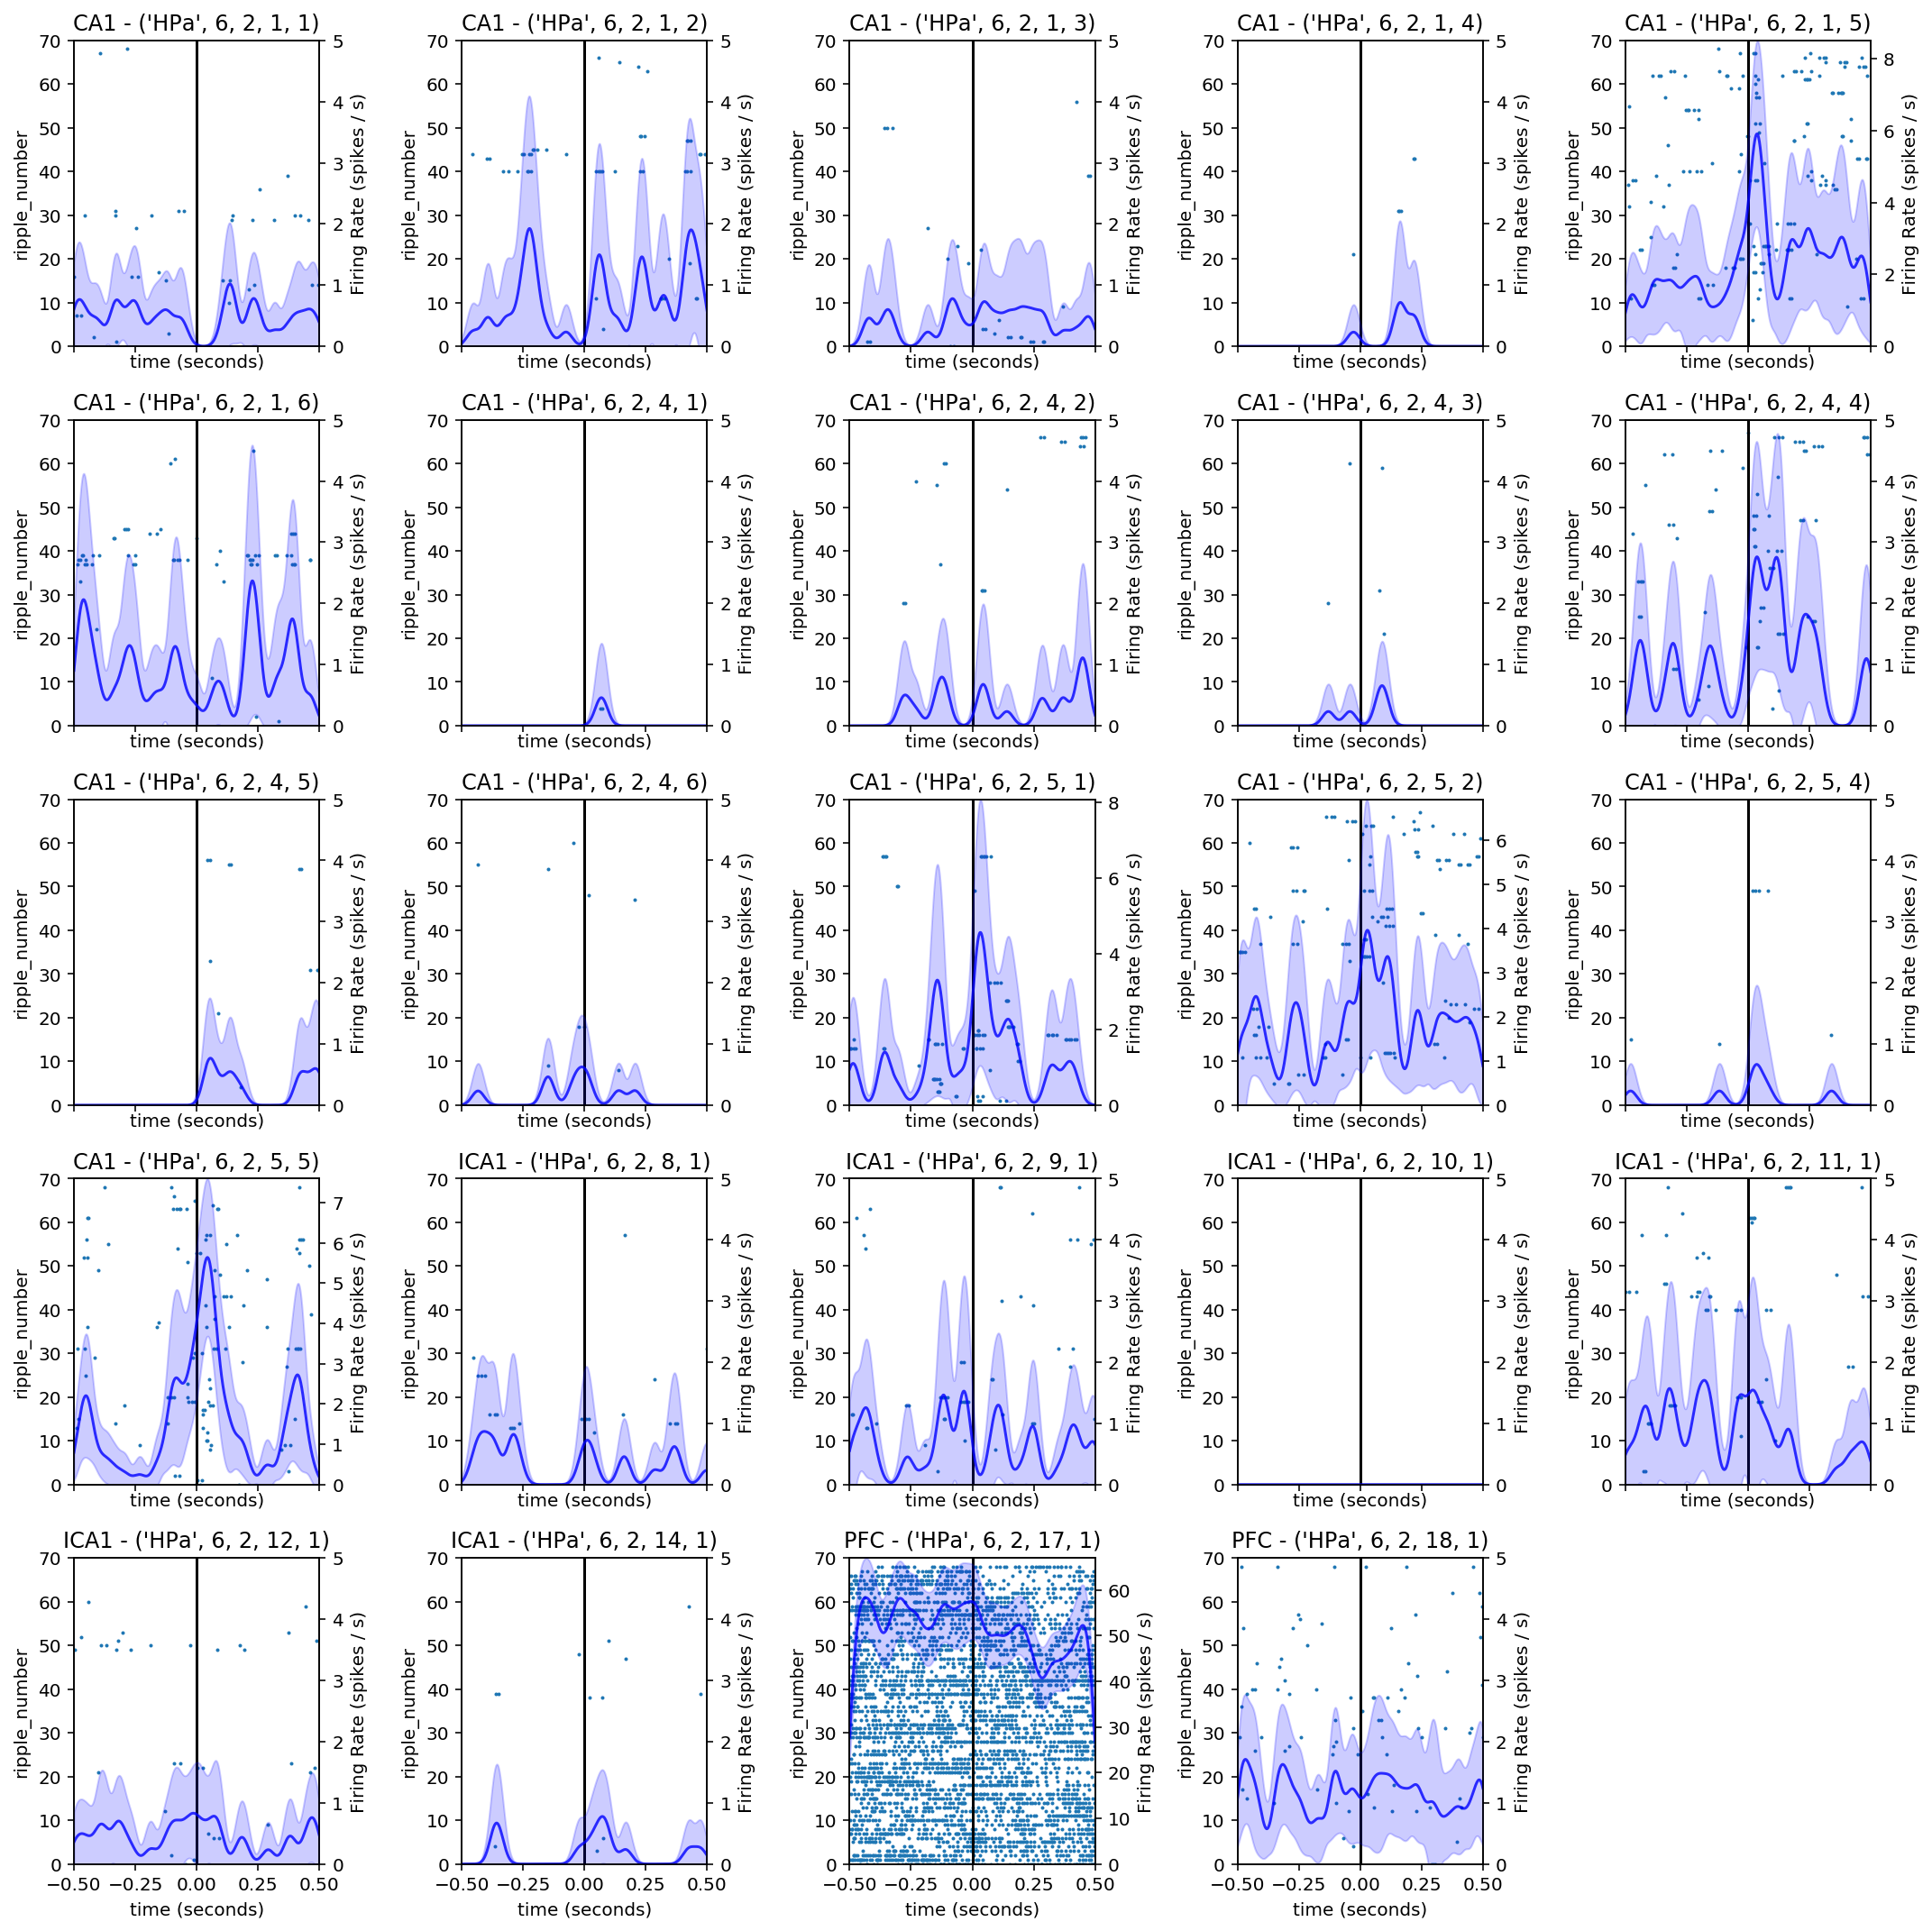

In [10]:
from src.visualization import plot_perievent_raster

neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

In [34]:
results = {}

results['ripple/constant'] = xr.concat(
    [fit_ripple_constant(
        neuron_key, ANIMALS, SAMPLING_FREQUENCY, ripple_times)
     for neuron_key in neuron_info.index], dim=neuron_info.neuron_id)
results['ripple/over_time'] = xr.concat(
    [fit_ripple_over_time(
        neuron_key, ANIMALS, SAMPLING_FREQUENCY, ripple_times,
        penalty=1E-4)
     for neuron_key in neuron_info.index], dim=neuron_info.neuron_id)


INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 1, 1)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 1, 2)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 1, 3)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 1, 4)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 1, 5)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 1, 6)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 4, 1)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 4, 2)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 4, 3)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 4, 4)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 4, 5)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 4, 6)
INFO:src.spike_models:Fitting ripple constant model for ('HPa', 6, 2, 5, 1)
INFO:src.spi

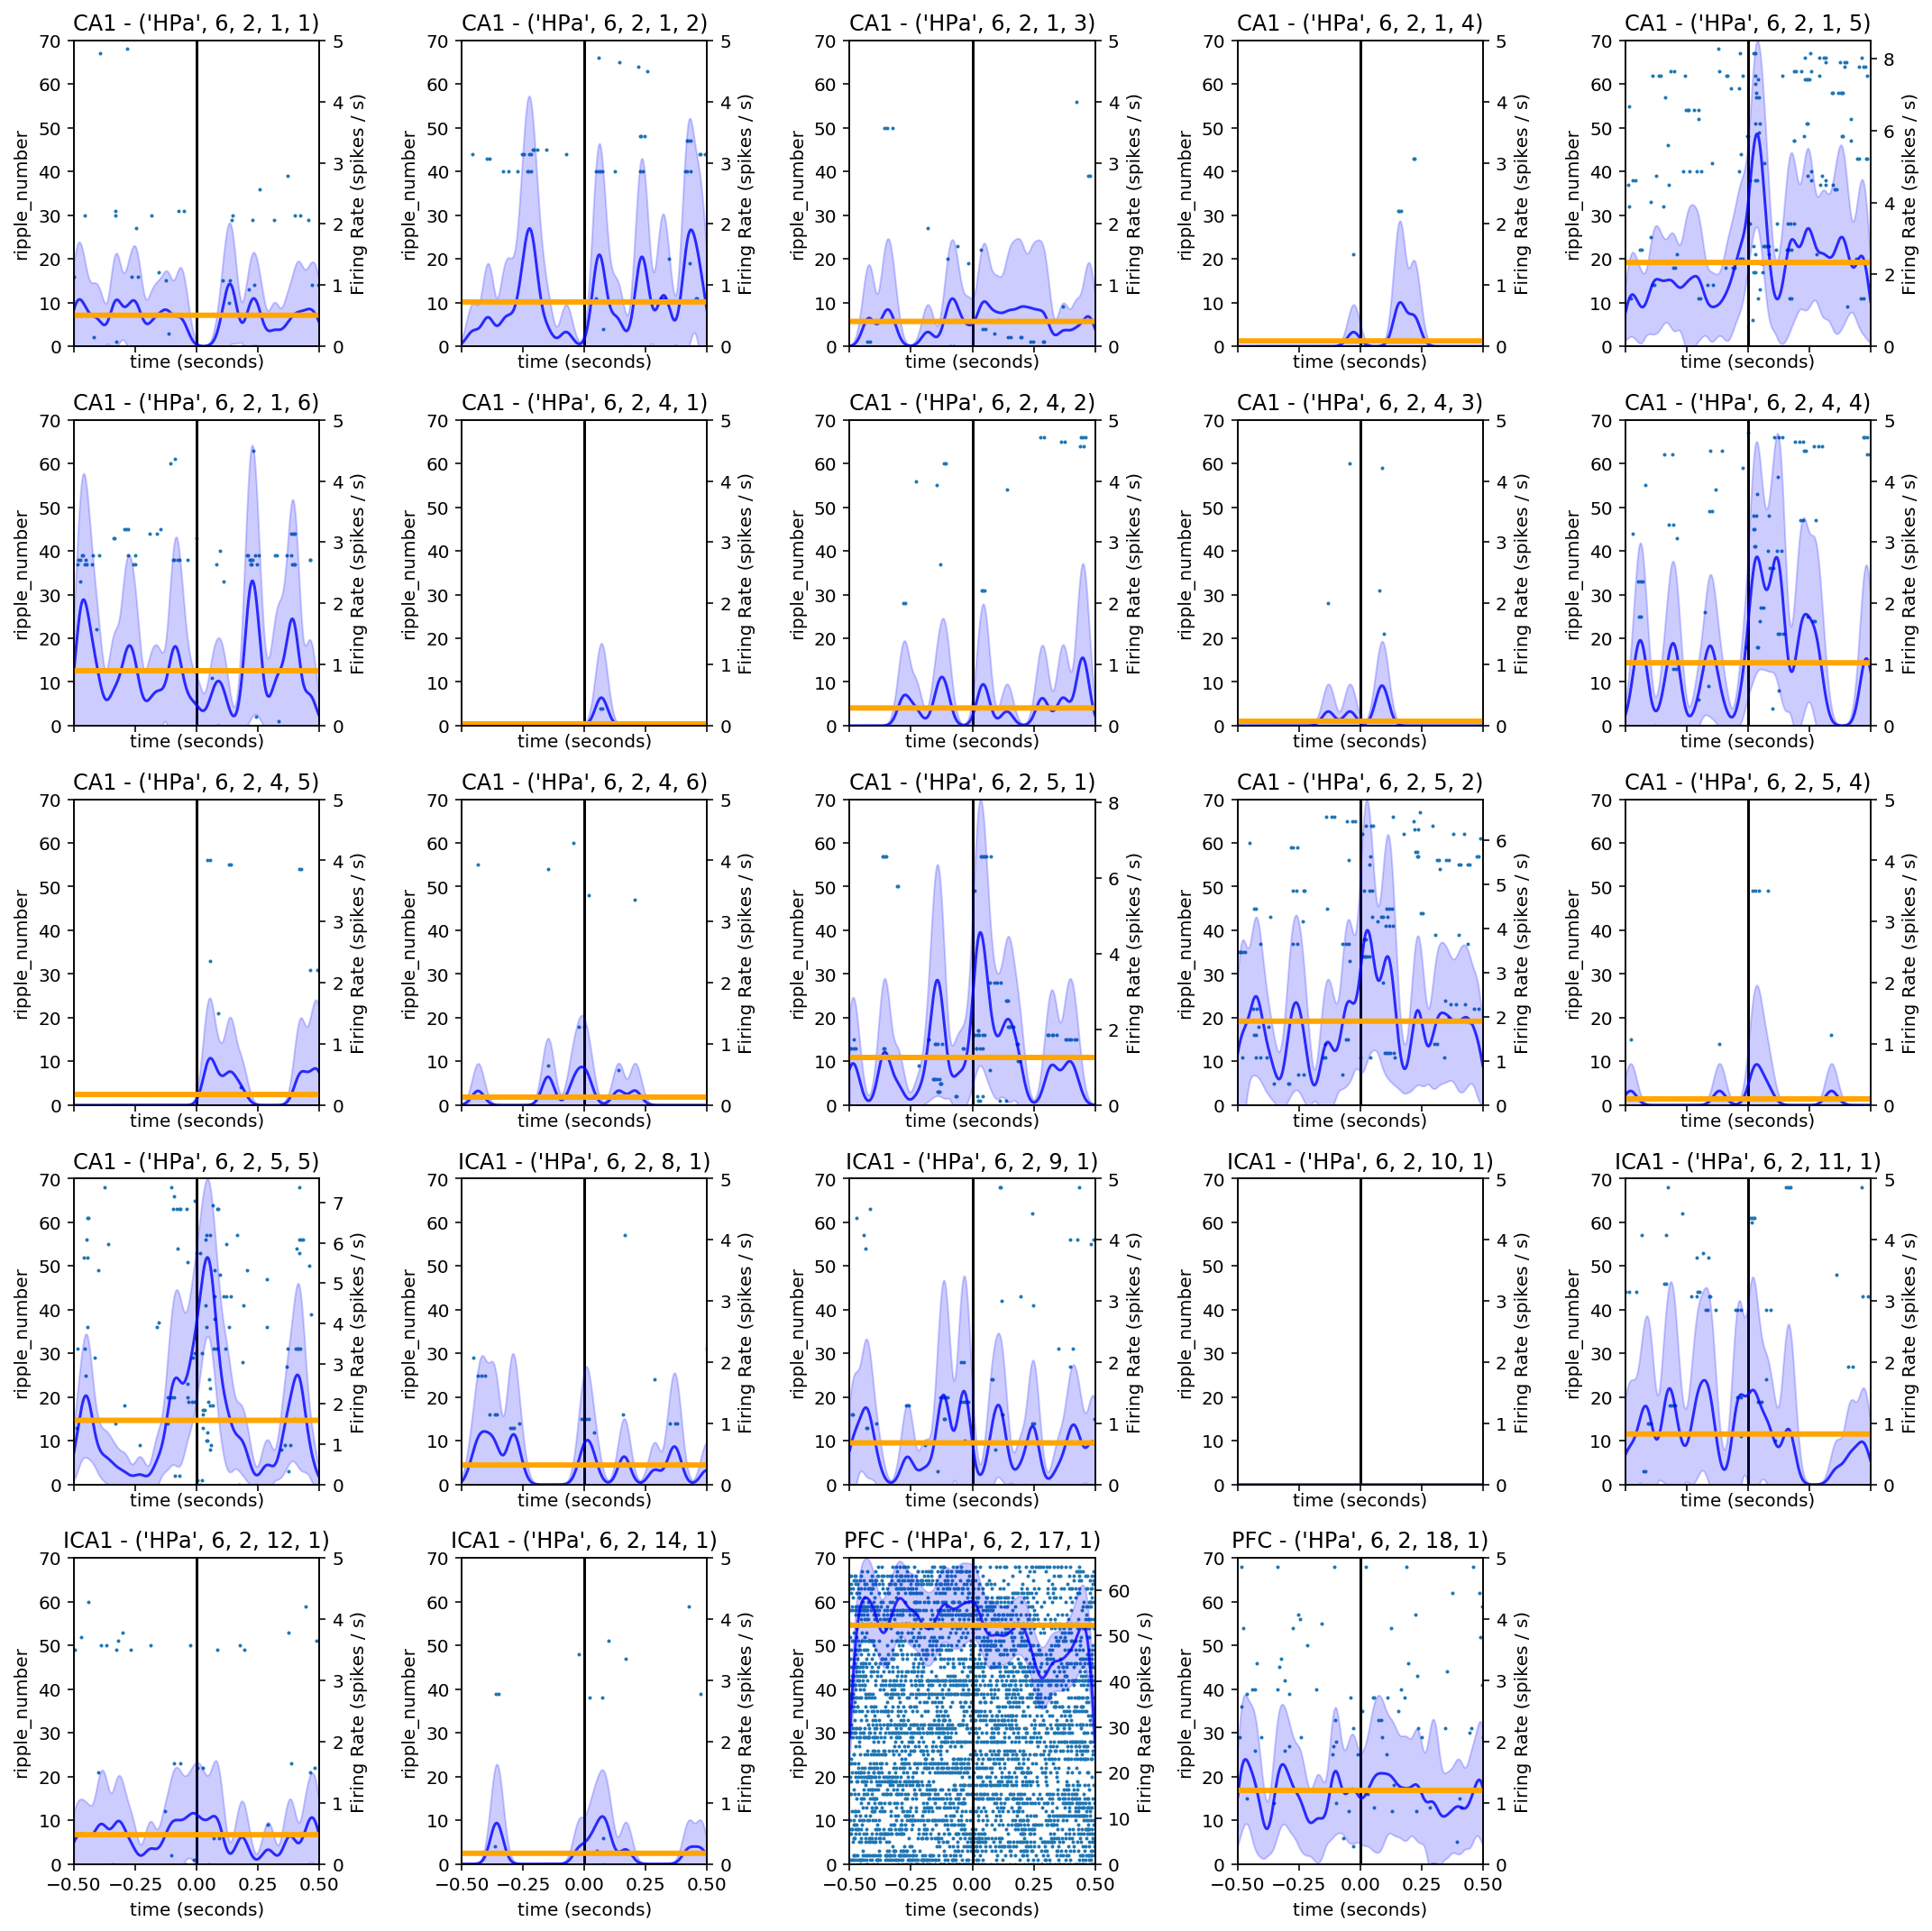

In [12]:
from src.visualization import plot_perievent_raster

neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    ax, ax2 = plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    predicted_rate = results['ripple/constant'].sel(
        neuron_id=neuron_info.loc[neuron_key].neuron_id).firing_rate
    ax2.plot(results['ripple/constant'].time, predicted_rate, color='orange', linewidth=3)

for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

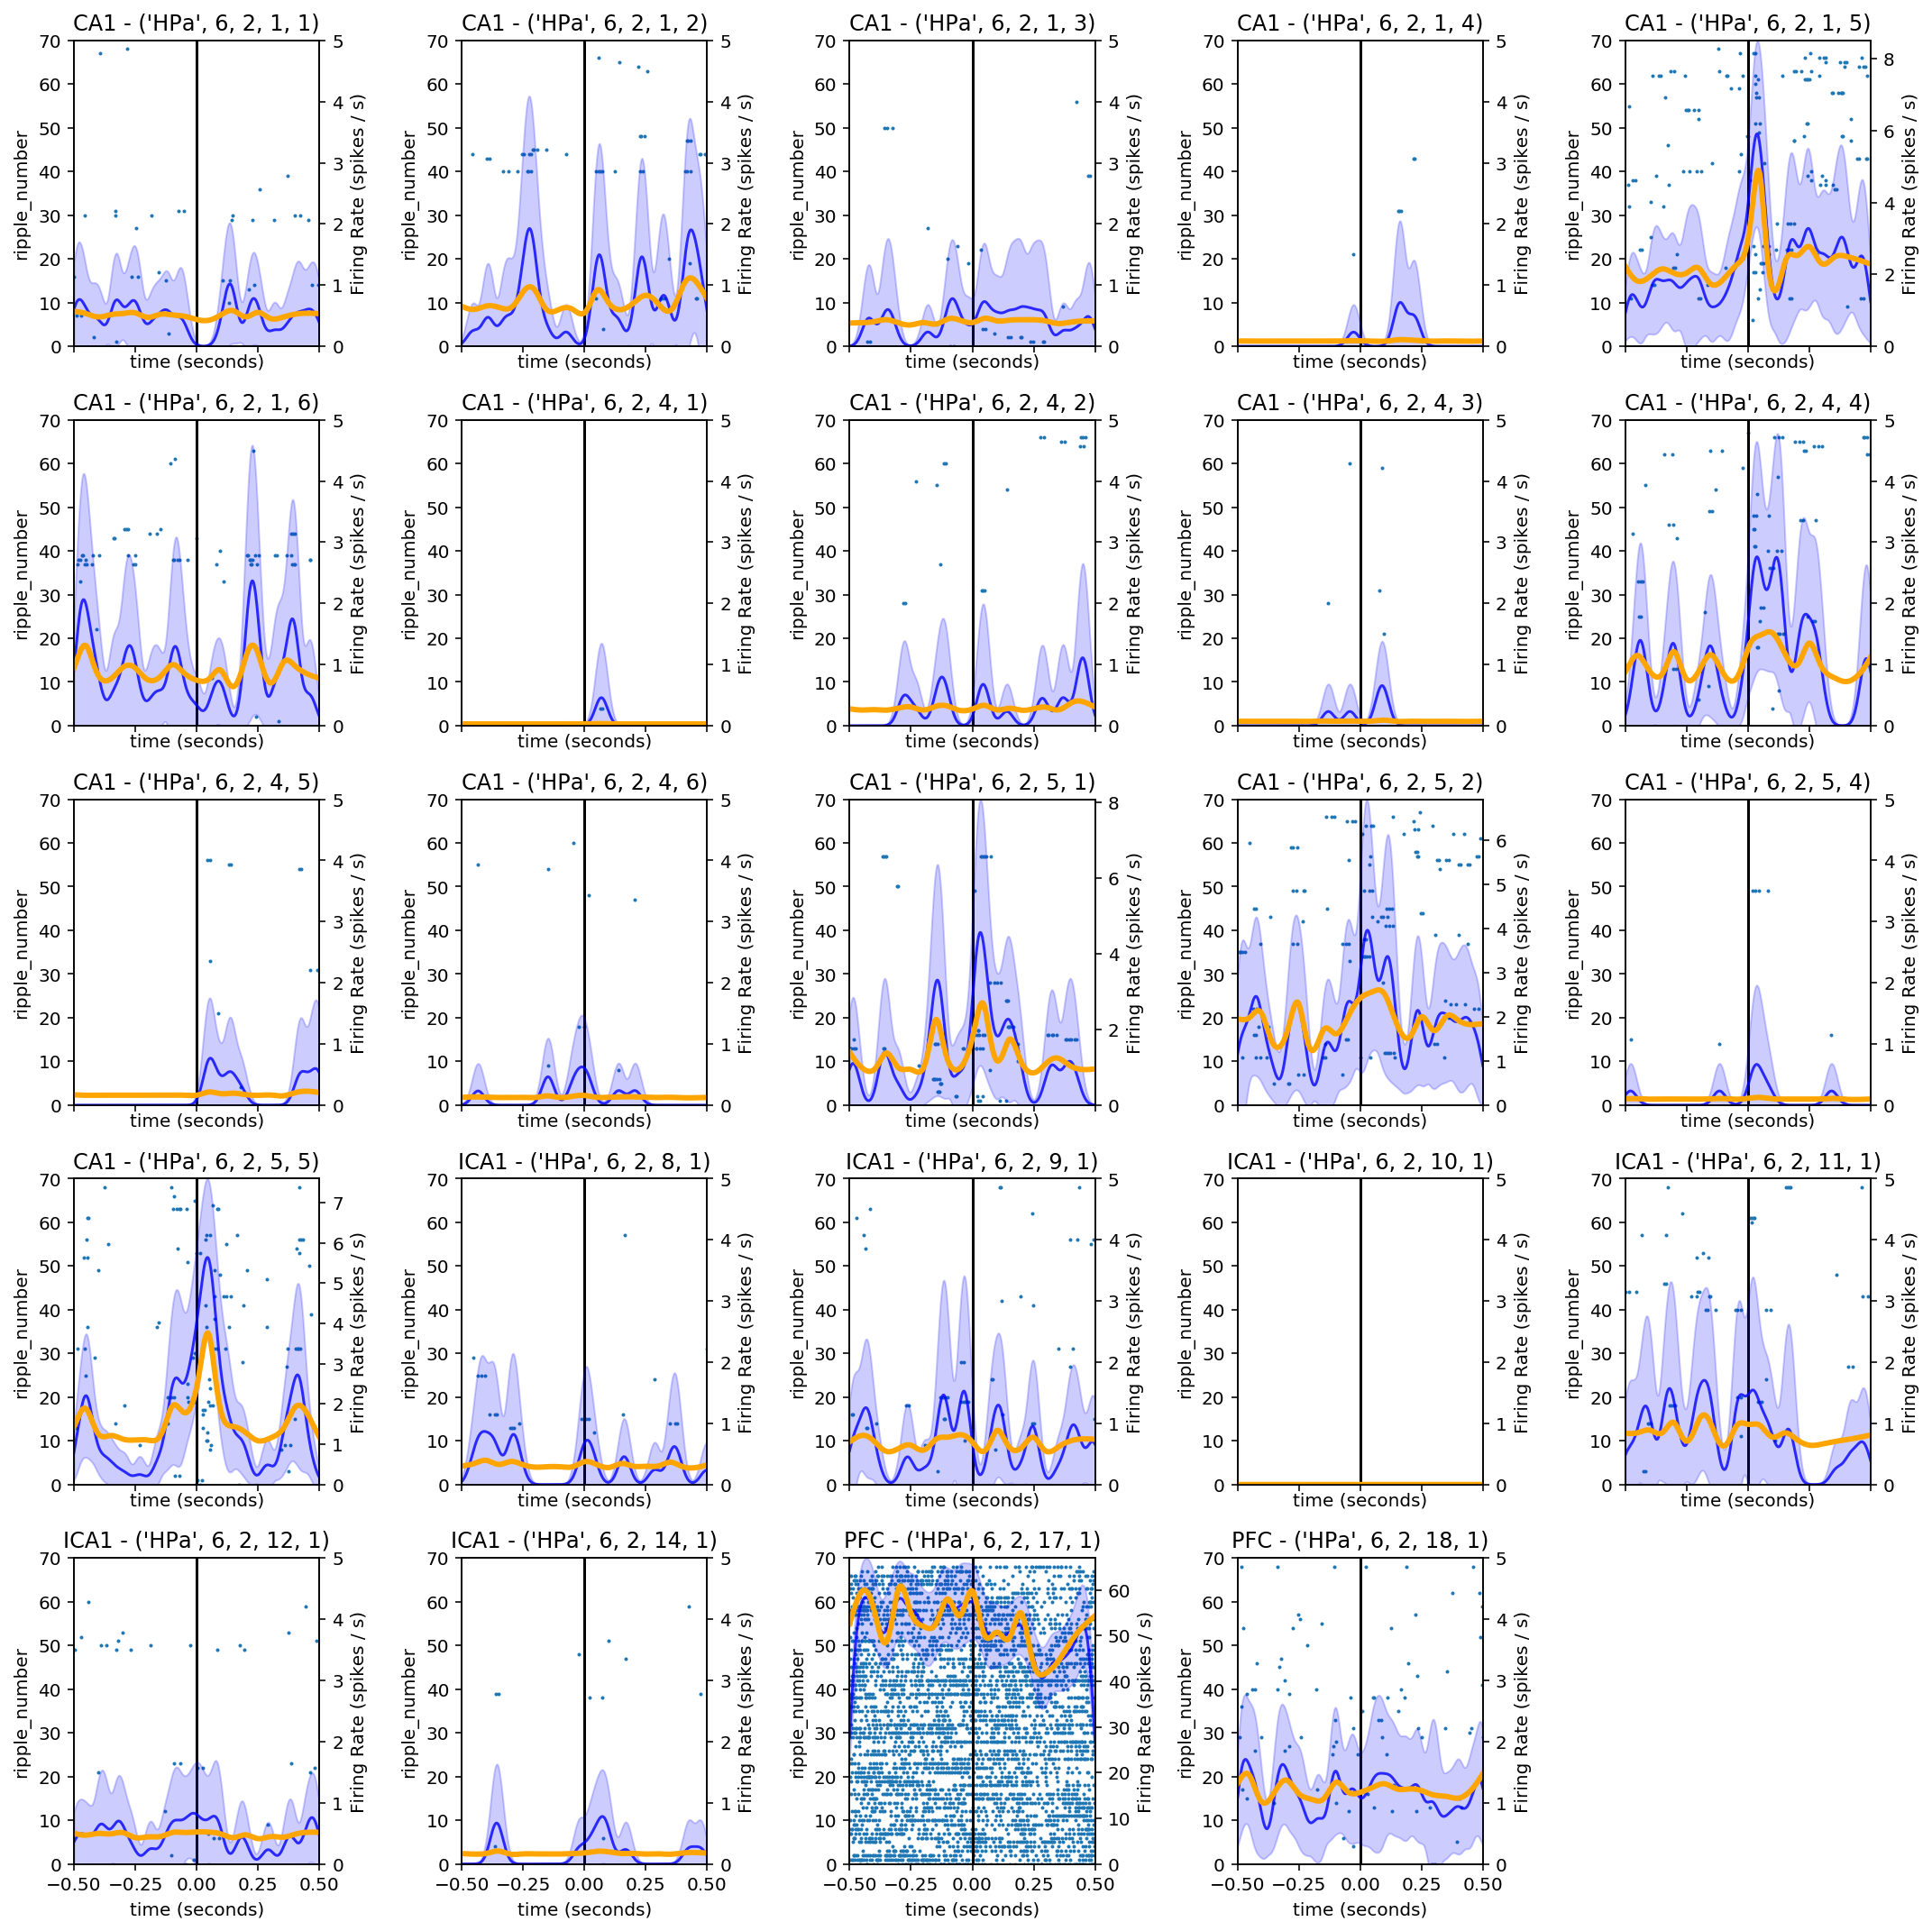

In [13]:
from src.visualization import plot_perievent_raster

neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    ax, ax2 = plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    predicted_rate = results['ripple/over_time'].sel(
        neuron_id=neuron_info.loc[neuron_key].neuron_id).firing_rate
    ax2.plot(results['ripple/over_time'].time, predicted_rate, color='orange', linewidth=3)
    

for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

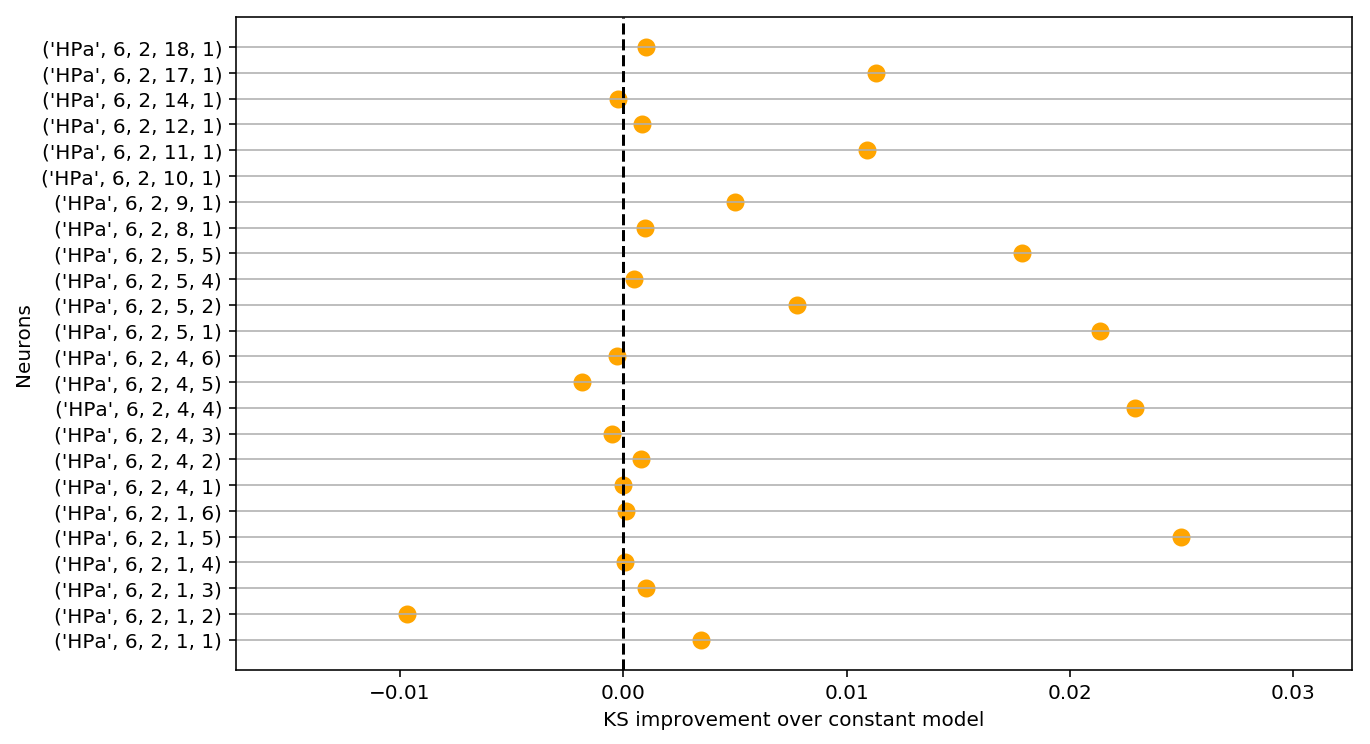

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ks_diff = (results['ripple/constant'].ks_statistic - results['ripple/over_time'].ks_statistic).values
ax.scatter(ks_diff, np.arange(ks_diff.size),
           color='orange', linewidth=3);
ax.axvline(0, color='black', linestyle='--')
ax.set_ylabel('Neurons')
ax.set_xlabel('KS improvement over constant model');
ax.set_yticks(np.arange(ks_diff.size));
ax.set_yticklabels(neuron_info.index);
ax.yaxis.grid(True)

In [163]:
results['ripple/replay_state'] = xr.concat(
    [fit_replay(
        neuron_key, ANIMALS, SAMPLING_FREQUENCY,  replay_info,
        'predicted_state', penalty=1E-4)
     for neuron_key in neuron_info.index], dim=neuron_info.neuron_id)


INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 1, 1) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 1, 2) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 1, 3) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 1, 4) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 1, 5) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 1, 6) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 4, 1) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 4, 2) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 4, 3) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 4, 4) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 4, 5) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 2, 4, 6

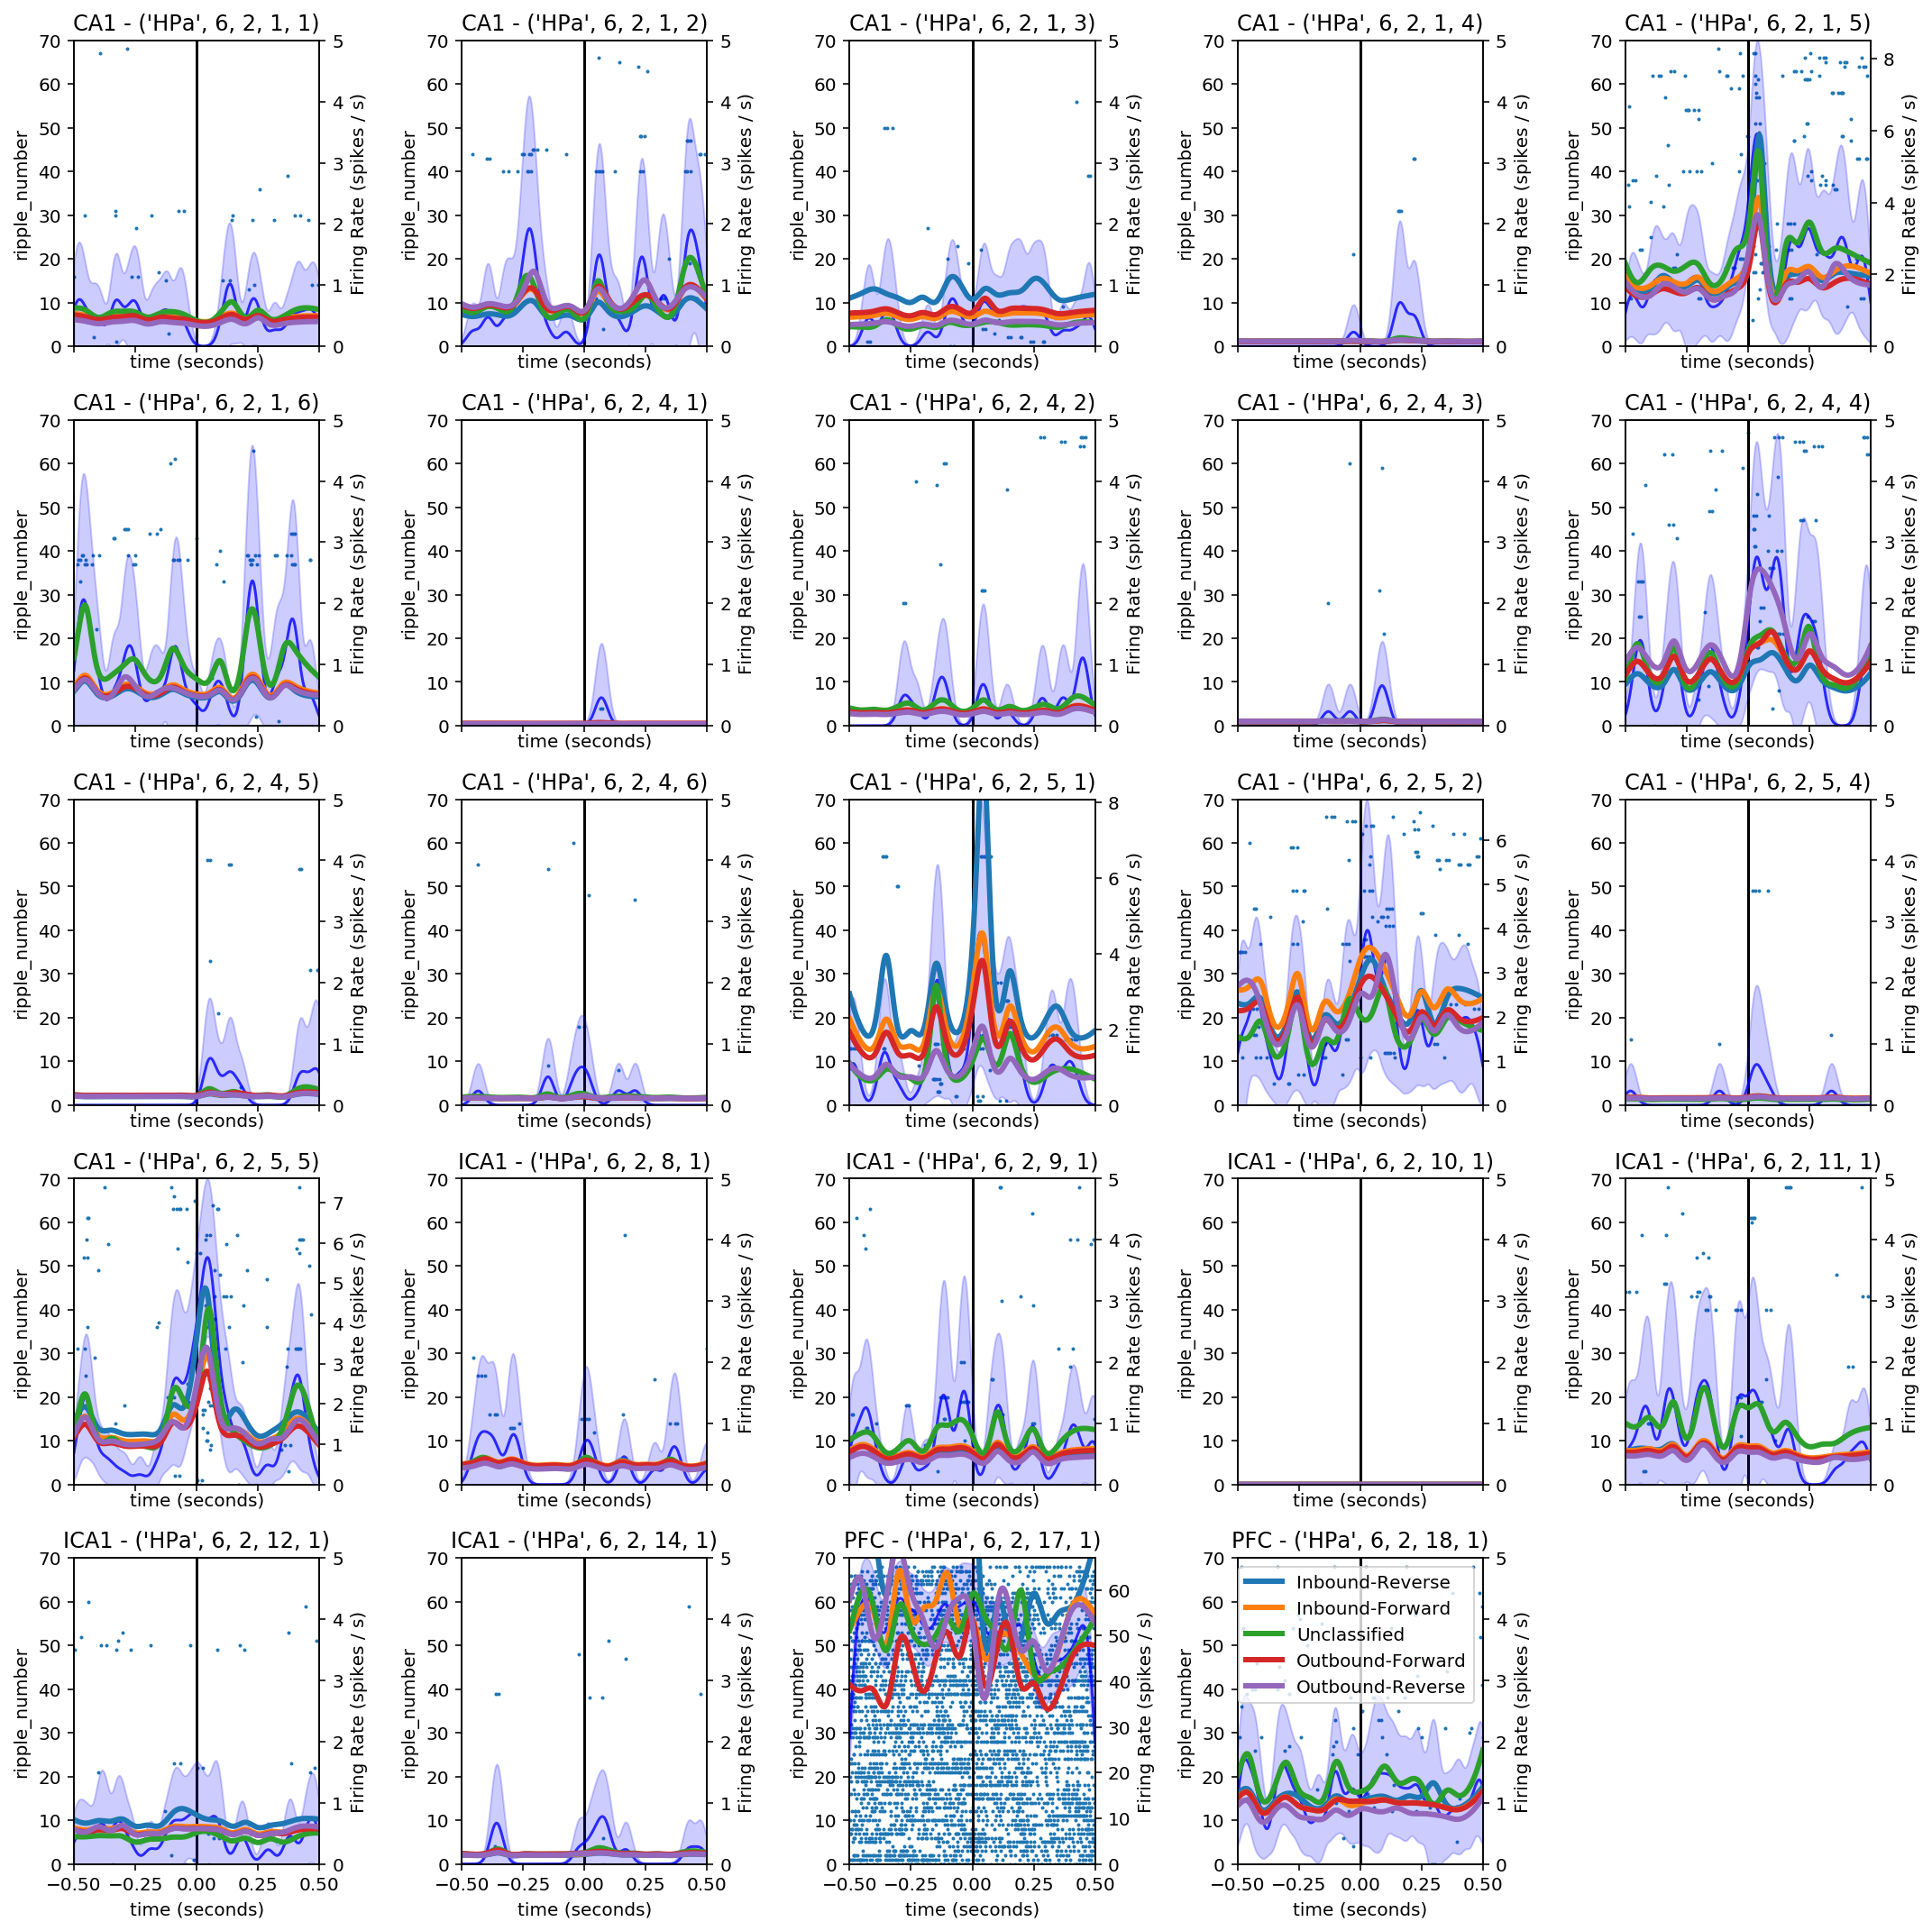

In [164]:
from src.visualization import plot_perievent_raster

neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    ax, ax2 = plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    predicted_rate = results['ripple/replay_state'].sel(
        neuron_id=neuron_info.loc[neuron_key].neuron_id).firing_rate.values.T
    l = ax2.plot(results['ripple/replay_state'].time, predicted_rate, linewidth=3)
    
    

for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')
    
plt.legend(l, results['ripple/replay_state'].predicted_state.values)

plt.tight_layout()

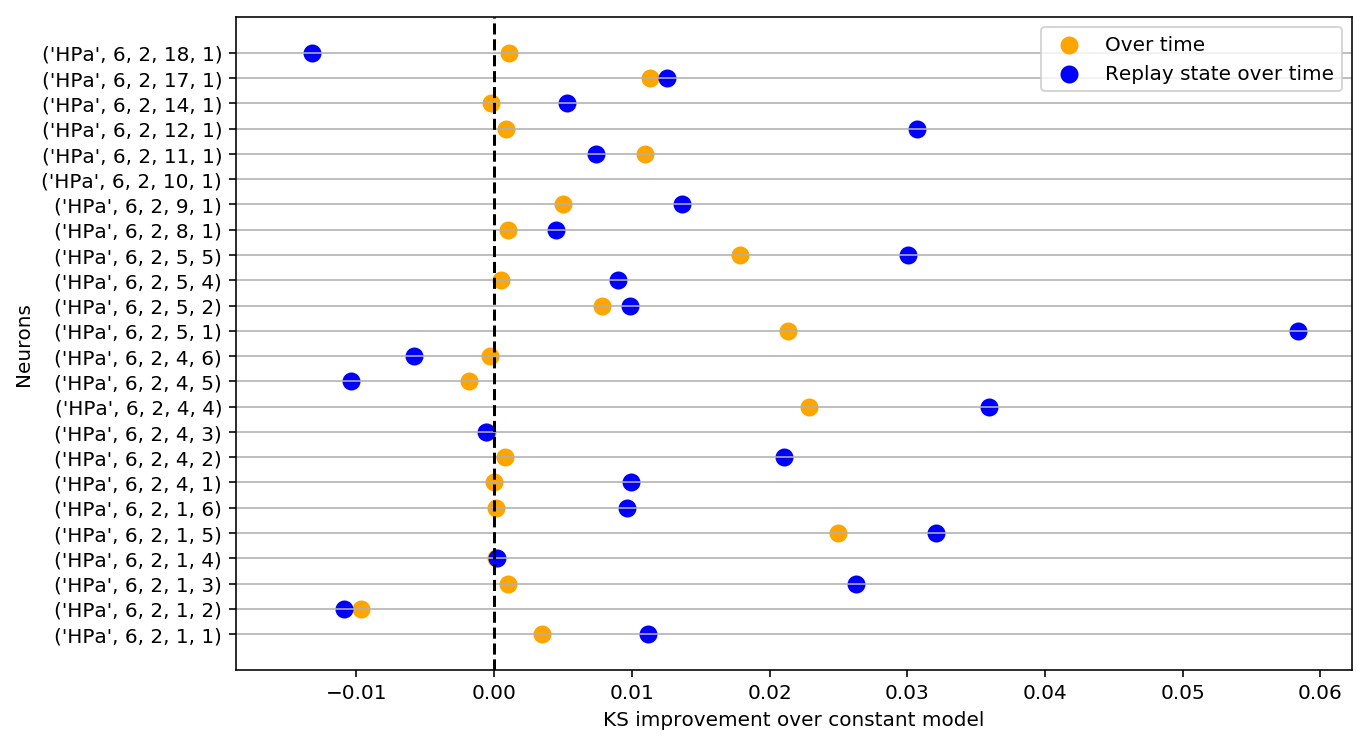

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ks_diff_over_time = (results['ripple/constant'].ks_statistic - results['ripple/over_time'].ks_statistic).values
ks_diff_replay_state = (results['ripple/constant'].ks_statistic - results['ripple/replay_state'].ks_statistic).values
ax.scatter(ks_diff_over_time, np.arange(ks_diff.size),
           color='orange', linewidth=3, label='Over time');
ax.scatter(ks_diff_replay_state, np.arange(ks_diff.size),
           color='blue', linewidth=3, label='Replay state over time');
ax.axvline(0, color='black', linestyle='--')
ax.set_ylabel('Neurons')
ax.set_xlabel('KS improvement over constant model');
ax.set_yticks(np.arange(ks_diff.size));
ax.set_yticklabels(neuron_info.index);
ax.yaxis.grid(True)

plt.legend();

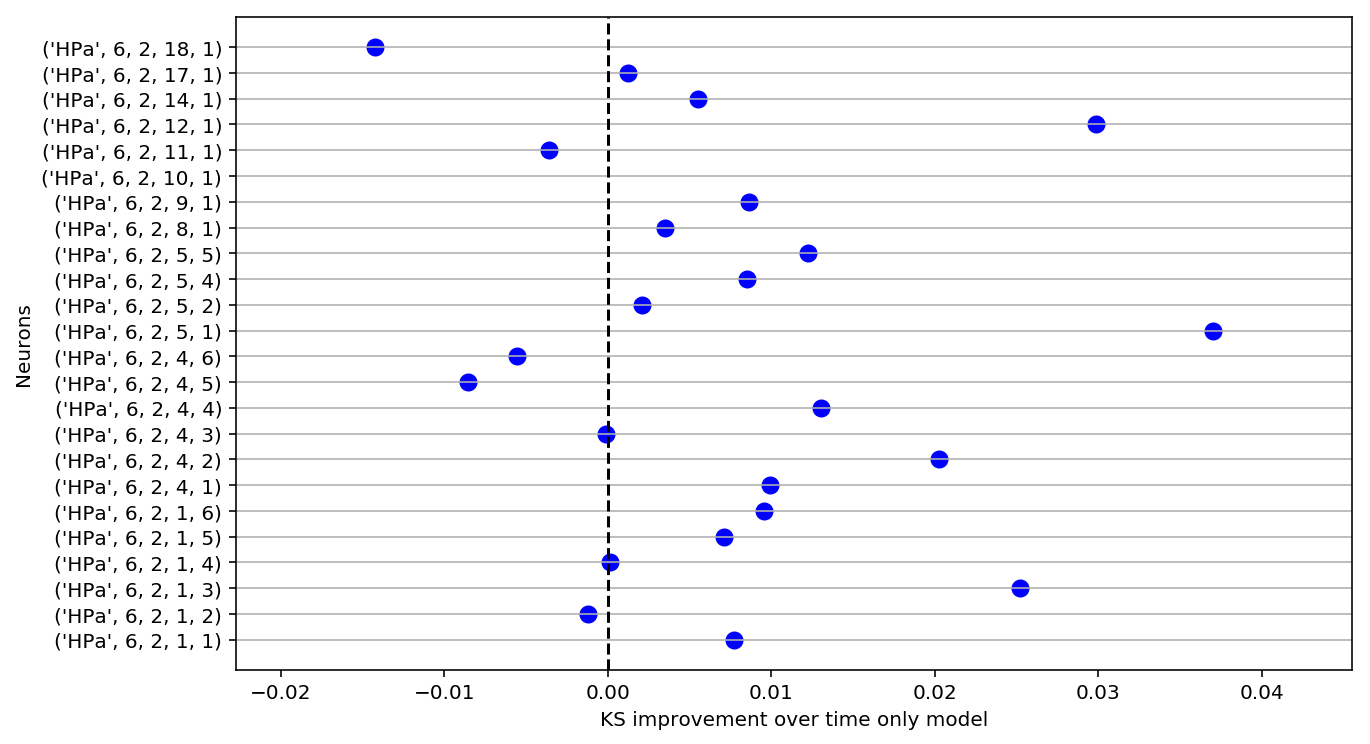

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ks_diff = (results['ripple/over_time'].ks_statistic - results['ripple/replay_state'].ks_statistic).values
ax.scatter(ks_diff, np.arange(ks_diff.size),
           color='blue', linewidth=3);
ax.axvline(0, color='black', linestyle='--')
ax.set_ylabel('Neurons')
ax.set_xlabel('KS improvement over time only model');
ax.set_yticks(np.arange(ks_diff.size));
ax.set_yticklabels(neuron_info.index);
ax.yaxis.grid(True)

In [167]:
from ipywidgets import interact

@interact(ripple_number=(1, len(replay_info)), continuous_update=False)
def plot_ripple(ripple_number):
    r = replay_info.loc[ripple_number-1]
    p = posterior_density.sel(concat_dim=ripple_number-1).dropna('time')

    l = p.plot(
        x='time', y='position', col='state', col_wrap=2, robust=True)

    for ax in l.axes.flat:
        ax.plot(position_info.loc[r.start_time:r.end_time].linear_distance.values,
                color='white', linestyle='--', linewidth=5)
    ds = (decision_state_probability.sel(concat_dim=ripple_number-1).dropna('time').drop('concat_dim')
     .to_dataframe().unstack(0))
    l = ds.plot(legend=False)
    l.legend(l.lines, ds.columns.droplevel());
    display(r.predicted_state)
    display(r.replay_motion)
    
    


interactive(children=(IntSlider(value=35, description='ripple_number', max=69, min=1), Output()), _dom_classes=('widget-interact',))